In [76]:
# Python standard libraries
import math
import random

# Packages for computation and modelling
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
import mne
import pickle

# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Self-defined packages
from swlda import SWLDA
from utils import *

# Magic command to reload packages whenever we run any later cells
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# Define my colors
MY_BLUE = '#2774AE'
MY_GOLD = '#FFD100'

In [78]:
BOARD = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"    ],
         ["I",    "J",  "K",   "L",    "M",    "N",     "O",    "P"    ],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"    ],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"    ],
         ["6",    "7",  "8",   "9",    "0",    "Prd",   "Ret",  "Bs"   ],
         ["?",    ",",  ";",   "\\",   "/",    "+",     "-",    "Alt"  ],
         ["Ctrl", "=",  "Del", "Home", "UpAw", "End",   "PgUp", "Shft" ],
         ["Save", "'",  "F2",  "LfAw", "DnAw", "RtAw",  "PgDn", "Pause"],
         ["Caps", "F5", "Tab", "EC",   "Esc",  "email", "!",    "Sleep"]]
BOARD  = np.array(BOARD)
N_ROWS = BOARD.shape[0]  # number of rows
N_COLS = BOARD.shape[1]  # number of columns
M = N_ROWS * N_COLS      # the number of chars on the board

In [79]:
paradigm       = 'RC'  # display paradigm ('RC', 'CB', or 'RD')
NUM_TIMESTAMPS = 195   # number of timestamps in each window to record signals
EPOCH_SIZE     = 15    # required number of features in every epoch
CORE_CHANNELS = ('EEG_Fz', 'EEG_Cz',  'EEG_P3',  'EEG_Pz',
                 'EEG_P4', 'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
NUM_CORE_CHANNELS  = len(CORE_CHANNELS)  # number of core eletrodes
NUM_TRAIN_WORDS = 5 # number of training words for one participant
NUM_TEST_WORDS  = 5 # number of testing words for one participant

In [80]:
obj_indices = ['01', '02', '03', '04', '05', '06', '07',
               '09', '14', '15', '16', '17', '19']

DS_detectabilities = []
DS_AUCs = []
DS_all_performance = []

for obj in obj_indices:
    directory = '/Users/zionshane/Desktop/Duke/Research/BCI_data/EDFData-StudyA'
    obj_directory = directory + f'/A{obj}/SE001'

    train_features,train_response = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='train',
                                              num_words=NUM_TRAIN_WORDS)

    test_features,test_response   = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='test',
                                              num_words=NUM_TEST_WORDS)

    try:
        f = open(f'./model/A{obj}-model.pkl', 'rb')
        clf = pickle.load(f)
    except:
        clf = SWLDA(penter=0.1, premove=0.15)
        clf.fit(train_features, train_response)
        # save the classifier as a standalone model file
        with open(f'./model/A{obj}-model.pkl','wb') as f:
            pickle.dump(clf,f)

    auc = clf.test(test_features, test_response)
    DS_AUCs.append(auc)

    scores = pd.DataFrame(clf.test(train_features), columns=['score'])
    scores['is_target'] = train_response.astype('int')
    mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
    mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])
    var_1 = std_1**2
    var_0 = std_0**2
    DS_detectability = (mu_1 - mu_0) / (math.sqrt((var_1 + var_0)/2))
    DS_detectabilities.append(DS_detectability)

    test_file_indices = ['06', '07', '08', '09', '10']
    participant_perform = []

    for file_index in test_file_indices:
        test_file = directory + ('/A%s/SE001/Test/%s/A%s_SE001%s_Test%s.edf'
                    % (obj, paradigm, obj, paradigm, file_index))
        raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

        stim_events = mne.find_events(raw=raw_data,
                                      stim_channel='StimulusBegin',
                                      verbose=False)
        eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
        raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
        test_epochs = get_core_epochs(raw_data)

        current_target_events=mne.find_events(raw_data,
                                              stim_channel='CurrentTarget',
                                              verbose=False)
        current_target = current_target_events[:,2]
        truth = eventIDs_to_sequence(BOARD, current_target)

        phases_events = mne.find_events(raw_data,
                                        stim_channel='PhaseInSequence',
                                        verbose=False)
        phases_appears = phases_events[:,0]
        during_trail_phases = []
        for i in range(1, len(phases_appears), 2):
            start = phases_appears[i]
            end = phases_appears[i+1]
            during_trail_phases.append((start, end))

        test_features, test_response = split_data(test_epochs,
                                                  n_channels=NUM_CORE_CHANNELS,
                                                  n_times=NUM_TIMESTAMPS,
                                                  n_samples=EPOCH_SIZE)
        stim_begin_events=mne.find_events(raw=raw_data,
                                          stim_channel='StimulusBegin',
                                          verbose=False)
        stim_begin_time = stim_begin_events[:,0]

        flashing_schedule=get_flashing_schedule(BOARD,raw_data,stim_begin_time)

        clf_scores = clf.test(data=test_features)

        NUM_SEQ = 7
        T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trial
        ACTUAL_T_MAX = int(len(stim_begin_time)/len(truth))
        P_threshold = 0.9

        trail_perform = {'truth':truth, 'select':[], 'times':[]}

        for trail in range(len(during_trail_phases)):
            P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M) # Initialize probs
            num_flashes = 0
            target_index = current_target[trail]
            target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
            start, end = during_trail_phases[trail]
            time = start
            k = 0

            while time < end:
                num_flashes += 1
                flashed = flashing_schedule[time]
                # Generate the classifier score
                y = clf_scores[trail*ACTUAL_T_MAX + k]
                # Update probabilities
                for i in range(N_ROWS):
                    for j in range(N_COLS):
                        ch_index = N_COLS * i + j + 1
                        if (ch_index in flashed):
                            likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                        else:
                            likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                        P_all[i, j] = P_all[i, j] * likelihood
                # Normalize P_all
                P_all = P_all / P_all.sum()
                # Check if can stop
                if P_all.max() >= P_threshold:
                    break
                else:
                    k += 1
                    if trail*ACTUAL_T_MAX + k == len(stim_begin_time):
                        break
                    else:
                        time = stim_begin_time[trail*ACTUAL_T_MAX + k]

            max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
            trail_perform['select'].append(BOARD[max_loc])
            trail_perform['times'].append(num_flashes)

        participant_perform.append(trail_perform)

    DS_all_performance.append(participant_perform)

In [81]:
# all_performance # check results [passed!]

# AUCs # check results [passed!]

In [82]:
AUC_df = pd.DataFrame({'index': obj_indices, 'AUC': DS_AUCs})
AUC_df.sort_values('AUC', inplace=True)

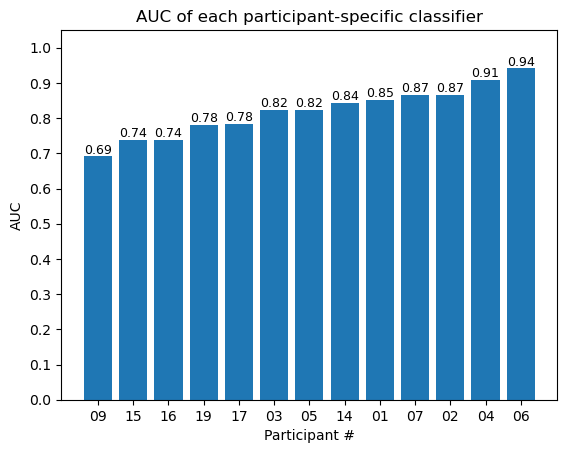

In [83]:
ax = plt.bar(x=AUC_df['index'], height=AUC_df['AUC'])
plt.bar_label(ax, labels=['%.2f'%(i) for i in AUC_df['AUC']], fontsize=9)
plt.xlabel('Participant #')
plt.ylabel('AUC')
plt.ylim(0, 1+0.05)
plt.yticks([0.1*i for i in range(11)])
plt.title('AUC of each participant-specific classifier')
plt.show()

In [84]:
def count_num_same(list_1, list_2):
    if (len(list_1) != len(list_2)):
        raise ValueError('The two input lists should have the same length!')
    num_same = 0
    for i in range(len(list_1)):
        if (list_1[i] == list_2[i]):
            num_same += 1

    return num_same

In [85]:
DS_accuracies = []
DS_trails = []
for participant_perform in DS_all_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    DS_accuracies.append(accuracy)
    DS_trails.append(detailed_trails)

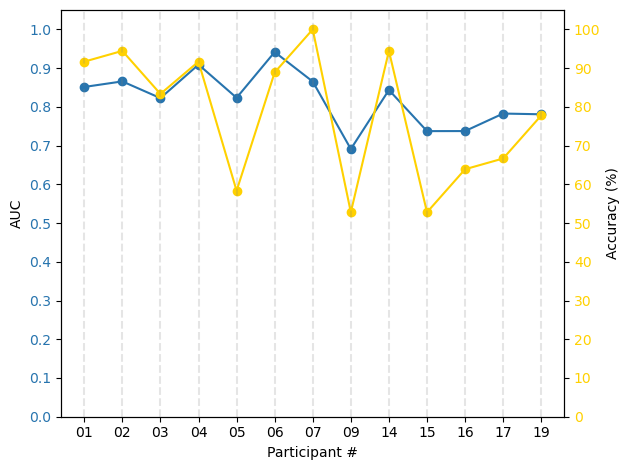

In [86]:
# NOTE: this plot is deprecated.
fig, ax1 = plt.subplots()

x = [i+1 for i in range(len(obj_indices))]

color = MY_BLUE
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel('AUC')
ax1.plot(x, DS_AUCs, marker='o', color=color)
ax1.set_ylim(0, 1+0.05)
ax1.set_yticks([0.1*i for i in range(11)])

ax1.set_xlabel('Participant #')
ax1.set_xticks(ticks=[i+1 for i in range(len(obj_indices))], labels=obj_indices)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = MY_GOLD
ax2.plot(x, DS_accuracies, marker='o', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel('Accuracy (%)')
ax2.set_ylim(0, 1+0.05)
ax2.set_yticks([0.1*i for i in range(11)], [10*i for i in range(11)])

for i in range(len(obj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

Text(0.5, 1.0, 'AUC-accuracy pairs of 13 participants')

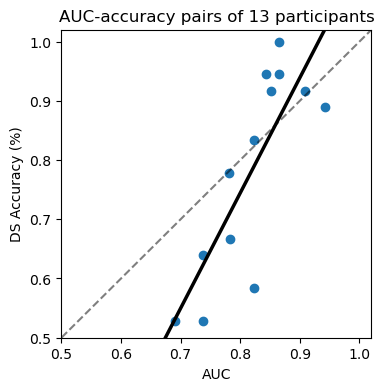

In [87]:
DS_accuracies_df = pd.DataFrame({'index': obj_indices, 'accuracy': DS_accuracies})
DS_accuracies_and_AUC_df = pd.merge(AUC_df, DS_accuracies_df, on="index")
plt.figure(figsize=(4,4))
plt.scatter(DS_accuracies_and_AUC_df['AUC'], DS_accuracies_and_AUC_df['accuracy'])
plt.plot([0, 1.02], [0, 1.02], ls='--', c='black', alpha=0.5)
b, a = np.polyfit(x=DS_accuracies_and_AUC_df['AUC'],
                  y=DS_accuracies_and_AUC_df['accuracy'], deg=1)
xseq = np.linspace(0.5, 1.02, num=50)
plt.plot(xseq, a + b * xseq, color="k", lw=2.5)
plt.xlim(0.5, 1.02)
plt.xlabel('AUC')
plt.ylim(0.5, 1.02)
plt.ylabel('DS Accuracy (%)')
plt.title('AUC-accuracy pairs of 13 participants')

In [88]:
DS_trails_df = pd.DataFrame({'index': obj_indices, 'trails': DS_trails})
DS_trails_and_AUC_df = pd.merge(AUC_df, DS_trails_df, on="index")
DS_trails_and_AUC_df.sort_values('AUC', inplace=True)

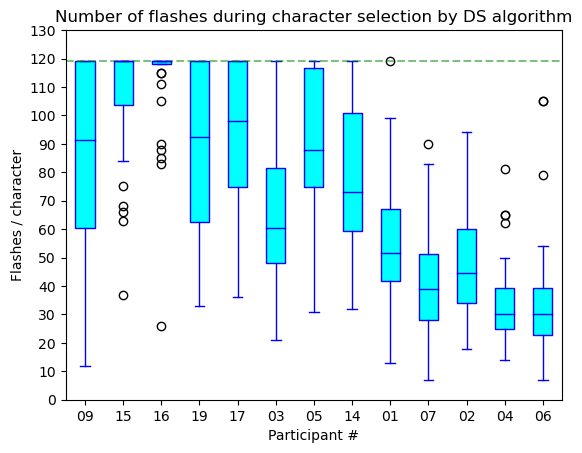

In [89]:
edge_color = 'blue'
fill_color = 'cyan'
bp = plt.boxplot(DS_trails_and_AUC_df['trails'], patch_artist=True)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color=edge_color)
for patch in bp['boxes']:
    patch.set(facecolor=fill_color)

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))],
           labels=DS_trails_and_AUC_df['index'])
plt.ylabel('Flashes / character')
plt.ylim(0, 130)
plt.yticks([10*i for i in range(14)])
plt.title('Number of flashes during character selection by DS algorithm')

plt.axhline(y=119, color='green', alpha=0.5, linestyle='--')
plt.show()

In [90]:
obj_indices = ['01', '02', '03', '04', '05', '06', '07',
               '09', '14', '15', '16', '17', '19']

SS_detectabilities = []
SS_AUCs = []
SS_all_performance = []

for obj in obj_indices:
    directory = '/Users/zionshane/Desktop/Duke/Research/BCI_data/EDFData-StudyA'
    obj_directory = directory + f'/A{obj}/SE001'

    train_features,train_response = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='train',
                                              num_words=NUM_TRAIN_WORDS)

    test_features,test_response   = load_data(dir=obj_directory,
                                              obj=obj,
                                              num_timestamps=NUM_TIMESTAMPS,
                                              epoch_size=EPOCH_SIZE,
                                              num_channels=NUM_CORE_CHANNELS,
                                              type=paradigm,
                                              mode='test',
                                              num_words=NUM_TEST_WORDS)

    try:
        f = open(f'./model/A{obj}-model.pkl', 'rb')
        clf = pickle.load(f)
    except:
        clf = SWLDA(penter=0.1, premove=0.15)
        clf.fit(train_features, train_response)
        # save the classifier as a standalone model file
        with open(f'./model/A{obj}-model.pkl','wb') as f:
            pickle.dump(clf,f)

    auc = clf.test(test_features, test_response)
    SS_AUCs.append(auc)

    scores = pd.DataFrame(clf.test(train_features), columns=['score'])
    scores['is_target'] = train_response.astype('int')
    mu_1, std_1 = norm.fit(data=scores.loc[scores['is_target'] == 1]['score'])
    mu_0, std_0 = norm.fit(data=scores.loc[scores['is_target'] == 0]['score'])
    var_1 = std_1**2
    var_0 = std_0**2
    SS_detectability = (mu_1 - mu_0) / (math.sqrt((var_1 + var_0)/2))
    SS_detectabilities.append(SS_detectability)

    test_file_indices = ['06', '07', '08', '09', '10']
    participant_perform = []

    for file_index in test_file_indices:
        test_file = directory + ('/A%s/SE001/Test/%s/A%s_SE001%s_Test%s.edf'
                    % (obj, paradigm, obj, paradigm, file_index))
        raw_data = mne.io.read_raw_edf(test_file, preload=True, verbose=False)

        stim_events = mne.find_events(raw=raw_data,
                                      stim_channel='StimulusBegin',
                                      verbose=False)
        eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'],'EEG')
        raw_data.notch_filter(freqs=60, picks=eeg_channels, verbose=False)
        test_epochs = get_core_epochs(raw_data)

        current_target_events=mne.find_events(raw_data,
                                              stim_channel='CurrentTarget',
                                              verbose=False)
        current_target = current_target_events[:,2]
        truth = eventIDs_to_sequence(BOARD, current_target)

        phases_events = mne.find_events(raw_data,
                                        stim_channel='PhaseInSequence',
                                        verbose=False)
        phases_appears = phases_events[:,0]
        during_trail_phases = []
        for i in range(1, len(phases_appears), 2):
            start = phases_appears[i]
            end = phases_appears[i+1]
            during_trail_phases.append((start, end))

        test_features, test_response = split_data(test_epochs,
                                                  n_channels=NUM_CORE_CHANNELS,
                                                  n_times=NUM_TIMESTAMPS,
                                                  n_samples=EPOCH_SIZE)
        stim_begin_events=mne.find_events(raw=raw_data,
                                          stim_channel='StimulusBegin',
                                          verbose=False)
        stim_begin_time = stim_begin_events[:,0]

        flashing_schedule=get_flashing_schedule(BOARD,raw_data,stim_begin_time)

        clf_scores = clf.test(data=test_features)

        NUM_SEQ = 7
        T_MAX = (N_ROWS + N_COLS) * NUM_SEQ # max number of flashes per trial
        ACTUAL_T_MAX = int(len(stim_begin_time)/len(truth))
        P_threshold = 0.9

        trail_perform = {'truth':truth, 'select':[], 'times':[]}

        for trail in range(len(during_trail_phases)):
            P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M) # Initialize probs
            num_flashes = 0
            target_index = current_target[trail]
            target_loc = ((target_index-1) // N_COLS, (target_index-1) % N_COLS)
            start, end = during_trail_phases[trail]
            time = start
            k = 0

            while time < end:
                num_flashes += 1
                flashed = flashing_schedule[time]
                # Generate the classifier score
                y = clf_scores[trail*ACTUAL_T_MAX + k]
                # Update probabilities
                for i in range(N_ROWS):
                    for j in range(N_COLS):
                        ch_index = N_COLS * i + j + 1
                        if (ch_index in flashed):
                            likelihood=stats.norm.pdf(x=y,loc=mu_1,scale=std_1)
                        else:
                            likelihood=stats.norm.pdf(x=y,loc=mu_0,scale=std_0)
                        P_all[i, j] = P_all[i, j] * likelihood
                # Normalize P_all
                P_all = P_all / P_all.sum()
                # Check if can stop
                k += 1
                if trail*ACTUAL_T_MAX + k == len(stim_begin_time):
                    break
                else:
                    time = stim_begin_time[trail*ACTUAL_T_MAX + k]

            max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
            trail_perform['select'].append(BOARD[max_loc])
            trail_perform['times'].append(num_flashes)

        participant_perform.append(trail_perform)

    SS_all_performance.append(participant_perform)

In [91]:
SS_accuracies = []
SS_trails = []
for participant_perform in SS_all_performance:
    detailed_trails = [] # for each character
    num_correct = 0
    num_all = 0
    for trail_perform in participant_perform:
        truth  = trail_perform['truth']
        select = trail_perform['select']
        times  = trail_perform['times']
        num_all += len(truth)
        num_correct += count_num_same(truth, select)
        detailed_trails += times
    accuracy = num_correct / num_all
    SS_accuracies.append(accuracy)
    SS_trails.append(detailed_trails)

In [92]:
SS_average_trials = [sum(trails) / len(trails) for trails in SS_trails]
SS_average_trials_df = pd.DataFrame({'index': obj_indices,
                                     'avg_trails': SS_average_trials})
SS_average_trials_and_AUC_df = pd.merge(AUC_df, SS_average_trials_df, on="index")

DS_average_trials = [sum(trails) / len(trails) for trails in DS_trails]
DS_average_trials_df = pd.DataFrame({'index': obj_indices,
                                     'avg_trails': DS_average_trials})
DS_average_trials_and_AUC_df = pd.merge(AUC_df, DS_average_trials_df, on="index")

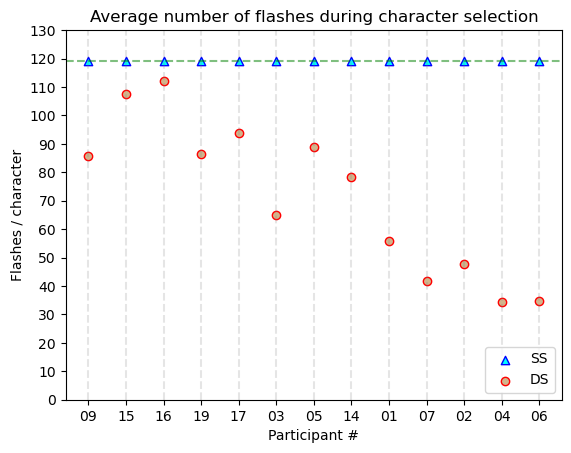

In [93]:
plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=SS_average_trials_and_AUC_df['avg_trails'],
            color='cyan', edgecolors='blue', marker='^', label='SS')

plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DS_average_trials_and_AUC_df['avg_trails'],
            color='tan', edgecolors='red', marker='o', label='DS')

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))], labels=AUC_df['index'])
plt.ylabel('Flashes / character')
plt.ylim(0, 130)
plt.yticks([10*i for i in range(14)])
plt.title('Average number of flashes during character selection')
plt.legend(loc=4)

plt.axhline(y=119, color='green', alpha=0.5, linestyle='--')
for i in range(len(obj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()

In [94]:
SS_accuracies_df = pd.DataFrame({'index': obj_indices, 'accuracy': SS_accuracies})
SS_accuracies_and_AUC_df = pd.merge(AUC_df, SS_accuracies_df, on="index")

DS_accuracies_df = pd.DataFrame({'index': obj_indices, 'accuracy': DS_accuracies})
DS_accuracies_and_AUC_df = pd.merge(AUC_df, DS_accuracies_df, on="index")

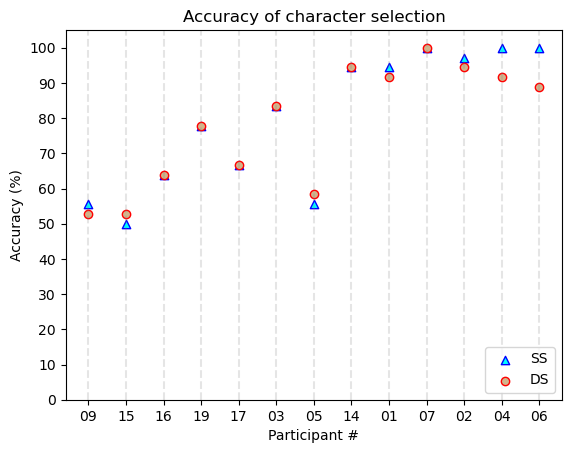

In [95]:
plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=SS_accuracies_and_AUC_df['accuracy'],
            color='cyan', edgecolors='blue', marker='^', label='SS')

plt.scatter(x=[i+1 for i in range(len(obj_indices))],
            y=DS_accuracies_and_AUC_df['accuracy'],
            color='tan', edgecolors='red', marker='o', label='DS')

plt.xlabel('Participant #')
plt.xticks(ticks=[i+1 for i in range(len(obj_indices))], labels=AUC_df['index'])
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1+0.05)
plt.yticks([0.1*i for i in range(11)], [10*i for i in range(11)])
plt.title('Accuracy of character selection')
plt.legend(loc=4)

for i in range(len(obj_indices)):
    plt.axvline(x=i+1, color='gray', alpha=0.2, linestyle='--')
plt.show()

In [96]:
# Initialization
num_seq= N_ROWS + N_COLS
seq = [i for i in range(num_seq)] # 0~8 are row 0~8, 9~16 are col 0~7
s = 10 # sequence_limit
t_max = 119 # the maximum time for data collection (number of trials)
N = 100 # number of iterations (one epoch per iteration)
target_loc = (1,0)
P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)

# Initailize means and stds for p(y|H0) and p(y|H1)
mu_0 = 0  # mean for p(y|H0) distribution
var_0 = 1 # variance for p(y|H1) distribution
std_0 = math.sqrt(var_0) # std for p(y|H0) distribution
mu_1 = 0
var_1 = 1
std_1 = math.sqrt(var_1)

# Run the simulation
accuracies = []
stopping_times = []
means = np.linspace(0, 5, 51)
detectabilities = (means - mu_0) / (math.sqrt((var_1 + var_0)/2))
for mean in means:
    mu_1 = mean
    n_hit = 0
    trial_times = 0
    for epoch in range(N):
        F = [random.sample(seq, len(seq)) for _ in range(s)] # stimulus codebook
        P_all = np.ones(shape=(N_ROWS, N_COLS)) * (1/M)
        for t in range(t_max):
            trial_times += 1
            # Flash a row or column
            flashed = F[t // num_seq][t % num_seq]
            flashed_row = flashed if flashed < 9 else -1
            flashed_col = flashed - 9 if flashed_row == -1 else -1
            # Randomly sample y from one of the two PDFs
            if (target_loc[0] == flashed_row or target_loc[1] == flashed_col):
                y = np.random.normal(loc=mu_1, scale=std_1)
            else:
                y = np.random.normal(loc=mu_0, scale=std_0)
            # Update probabilities
            for i in range(N_ROWS):
                for j in range(N_COLS):
                    if (i == flashed_row or j == flashed_col):
                        likelihood = stats.norm.pdf(x=y, loc=mu_1, scale=std_1)
                    else:
                        likelihood = stats.norm.pdf(x=y, loc=mu_0, scale=std_0)
                    P_all[i, j] = P_all[i, j] * likelihood
            # Normalize P_all
            P_all = P_all / P_all.sum()
            # Check if can stop
            if P_all.max() >= P_threshold:
                break
        max_loc = np.unravel_index(P_all.argmax(), P_all.shape)
        if (max_loc == target_loc):
            n_hit += 1
    accuracies.append(n_hit / N)
    stopping_times.append(trial_times / N)

In [97]:
DS_detectabilities_df = pd.DataFrame({'index': obj_indices,
                                      'detectability': DS_detectabilities})
DS_accs_and_detectability_df = pd.merge(DS_accuracies_df, DS_detectabilities_df,
                                        on="index")
DS_avgtrials_and_detectability_df = pd.merge(DS_average_trials_df,
                                             DS_detectabilities_df,
                                             on="index")

SS_detectabilities_df = pd.DataFrame({'index': obj_indices,
                                      'detectability': SS_detectabilities})
SS_accs_and_detectability_df = pd.merge(SS_accuracies_df, SS_detectabilities_df,
                                        on="index")
SS_avgtrials_and_detectability_df = pd.merge(SS_average_trials_df,
                                             SS_detectabilities_df,
                                             on="index")

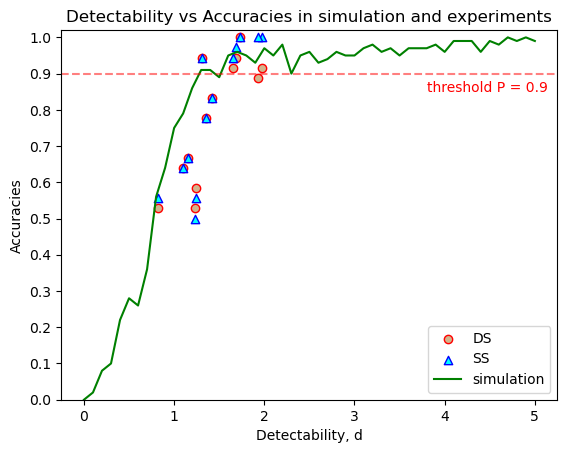

In [119]:
plt.scatter(x=DS_accs_and_detectability_df['detectability'],
            y=DS_accs_and_detectability_df['accuracy'], marker='o',
            color='tan', edgecolors='red', label='DS')
plt.scatter(x=SS_accs_and_detectability_df['detectability'],
            y=SS_accs_and_detectability_df['accuracy'], marker='^',
            color='cyan', edgecolors='blue', label='SS')
plt.plot(detectabilities, accuracies, c='g', label='simulation')
plt.title('Detectability vs Accuracies in simulation and experiments')
plt.ylim(0, 1.02)
plt.yticks(ticks=[0.1*i for i in range(11)])
plt.xlabel('Detectability, d')
plt.ylabel('Accuracies')
plt.axhline(y=0.9, color='r', alpha=0.5, linestyle='--')
plt.text(x=3.8, y=0.85, s='threshold P = 0.9', color='r')
plt.legend()

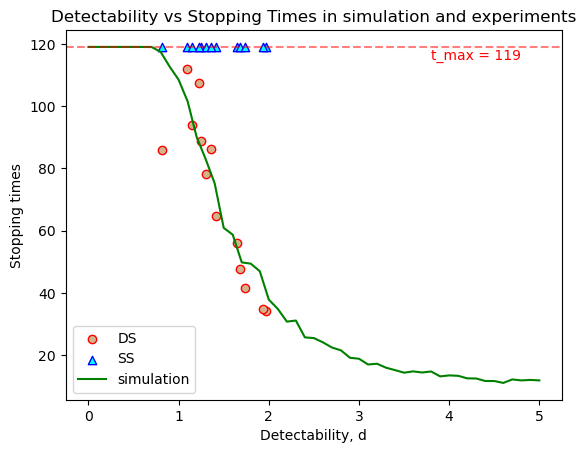

In [120]:
plt.scatter(x=DS_avgtrials_and_detectability_df['detectability'],
            y=DS_avgtrials_and_detectability_df['avg_trails'], marker='o',
            color='tan', edgecolors='red', label='DS')
plt.scatter(x=SS_avgtrials_and_detectability_df['detectability'],
            y=SS_avgtrials_and_detectability_df['avg_trails'], marker='^',
            color='cyan', edgecolors='blue', label='SS')
plt.plot(detectabilities, stopping_times, c='g', label='simulation')
plt.title('Detectability vs Stopping Times in simulation and experiments')
plt.xlabel('Detectability, d')
plt.ylabel('Stopping times')
plt.axhline(y=119, color='r', alpha=0.5, linestyle='--')
plt.text(x=3.8, y=115, s='t_max = 119', color='r')
plt.legend()